https://www.analyticsvidhya.com/blog/2016/04/complete-tutorial-tree-based-modeling-scratch-in-python/

In [1]:
import processing
import ds
import ml
import model_saving
import TS
import TA

/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


In [2]:
filename = '/home/octo/Dropbox'+ '/SPY21Dec.csv'

In [3]:
# Load the necessary packages and modules
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import pandas as pd
import numpy
import numpy as np
import math as m

In [4]:
data=processing.get_csv_pd(filename)
data=processing.BA(data)
data=processing.preprocessing(data)
data_km=ml.kalman_ma(data)
data['km']=data_km

In [5]:
data['diff']=np.where(np.logical_and(data.Open>data.km,data.spread>0),data.vwap-data.km,np.where(np.logical_and(data.Open<data.km,data.spread<0),data.vwap-data.km,0))

In [69]:
ta_data=data[['Close','diff','vel','vwap','liq']]

In [70]:
n = 12
roc_= TA.ROC(data,n)
ta_data['roc'] = roc_['Rate of Change']

In [71]:
n = 50
ewma_= TA.EWMA(data,n)
ta_data['ewma'] = ewma_['EWMA_50']

In [72]:
n = 20
sma_= TA.SMA(data,n)
ta_data['sma'] = sma_['SMA']

In [73]:
import talib

In [74]:
adx=talib.ADX(np.array(data.High.astype('float64')),np.array(data.Low.astype('float64')),np.array(data.Close.astype('float64')),12)

In [75]:
ta_data['adx'] = adx

In [76]:
# Defining target variable
Y=np.where(data.Close.diff(12)>0,1,-1)
ta_data['Y']=Y

    https://www.quantinsti.com/blog/use-decision-trees-machine-learning-predict-stock-movements/
    
    https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/
    

In [81]:
ta_data=ta_data[2000:12000].dropna()

In [82]:
X=ta_data[['diff','vel','vwap','liq','roc','ewma','sma','adx']]
Y=ta_data.Y

In [83]:
ta_data.tail()

,Close,diff,vel,vwap,liq,roc,ewma,sma,adx,Y
2017-12-21 21:23:10.509075,267.57999,0.00000,0.00000,267.57999,0.00000,0.00009,267.56510,267.56625,73.49531,1
2017-12-21 21:23:11.220797,267.57999,0.00000,0.00500,267.58582,0.01001,0.00006,267.56568,267.56750,74.74585,1
2017-12-21 21:23:11.992278,267.58499,0.00000,0.00500,267.58850,0.01001,0.00007,267.56644,267.56900,75.89217,1
2017-12-21 21:23:12.952875,267.58499,0.00000,0.00500,267.58850,0.01001,0.00004,267.56717,267.57050,76.94296,1
2017-12-21 21:23:13.861346,267.58499,0.00000,0.00998,267.58850,0.01001,0.00004,267.56787,267.57200,77.90619,1


In [84]:
# training set and test set
split_percentage=0.7
split=int(split_percentage*len(ta_data))
X_train=X[:split]
Y_train=Y[:split]
X_test=X[split:]
Y_test=Y[split:]

In [85]:
#Import Library
#Import other necessary libraries like pandas, numpy...
from sklearn import tree
#Assumed you have, X (predictor) and Y (target) for training data set and x_test(predictor) of test_dataset
# Create tree object 
model = tree.DecisionTreeClassifier(criterion='gini') # for classification, here you can change the algorithm as gini or entropy (information gain) by default it is gini  
# model = tree.DecisionTreeRegressor() for regression
# Train the model using the training sets and check score
model.fit(X_train,Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [86]:
model.score(X_train,Y_train)
#Predict Output
predicted= model.predict(X_test)

In [87]:
model.score(X_test,Y_test)

1.0

In [88]:
from sklearn.metrics import accuracy_score
accuracy_train=accuracy_score(Y_train,model.predict(X_train))
accuracy_test=accuracy_score(Y_test,model.predict(X_test))
print('training set sccuracy: %2.f' %accuracy_train)
print('test set sccuracy: %2.f' %accuracy_test)

training set sccuracy:  1
test set sccuracy:  1


In [91]:
# Creating trading strategy
ta_data['pr_signal']=model.predict(X)
ta_data['ret']=np.log(ta_data.Close/ta_data.Close.shift(12))
cum_ret=ta_data[split:].ret.cumsum()*100
ta_data['strat_ret']=ta_data.ret*ta_data.pr_signal.shift(1)
cum_strat_ret=ta_data[split:].strat_ret.cumsum()*100

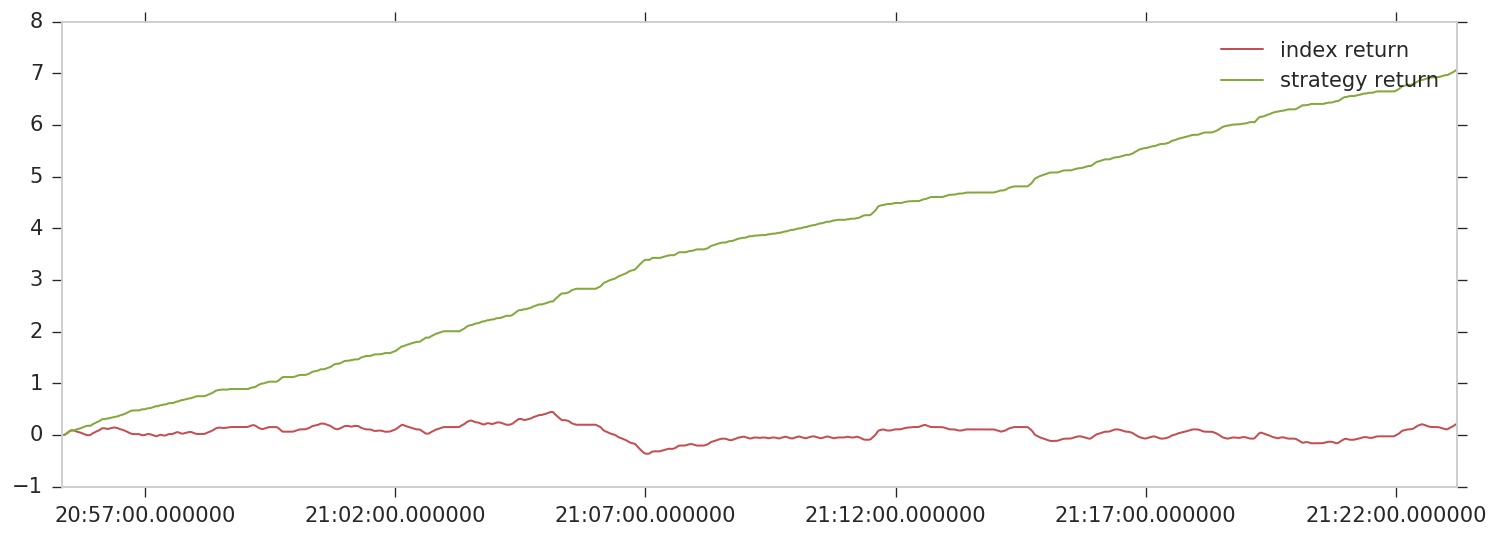

In [92]:
#plot
plt.figure(figsize=(15,5))
plt.plot(cum_ret,color='r',label='index return')
plt.plot(cum_strat_ret,color='g',label='strategy return')
plt.legend()
plt.show()

In [93]:
# sharp ratio
std=cum_strat_ret.std()
Sharpe=(cum_strat_ret-cum_ret)/std
Sharpe=Sharpe.mean()
print('Sharpe ratio: %.2f' %Sharpe)

Sharpe ratio: 1.69


In [94]:
data_feature_names =['diff','vel','vwap','liq','roc','ewma','sma','adx']

In [99]:
import pydotplus
import collections
# Visualize data
dot_data = tree.export_graphviz(model,
                                feature_names=data_feature_names,
                                out_file=None,
                                filled=True,
                                rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
 
colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)
 
for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))
 
for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])
 
graph.write_png('tree.png')

True

https://pythonprogramminglanguage.com/decision-tree-visual-example/

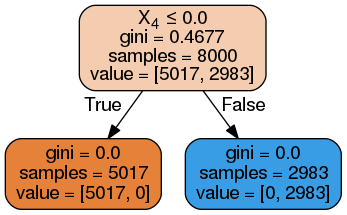

In [103]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
model_tree = tree.DecisionTreeClassifier()
model_tree.fit(X,Y)
export_graphviz(model_tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

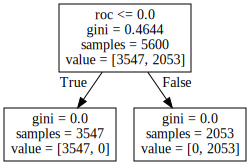

In [105]:
from graphviz import Source
from sklearn import tree
Source( tree.export_graphviz(model, out_file=None, feature_names=X.columns))

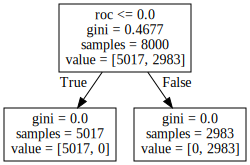

In [106]:
from IPython.display import SVG
graph = Source( tree.export_graphviz(model_tree, out_file=None, feature_names=X.columns))
SVG(graph.pipe(format='svg'))

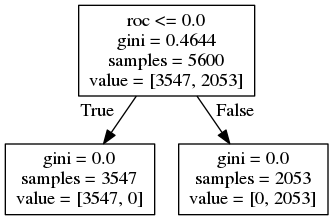

In [107]:
#Get the png image, save it and view it:
graph = Source( tree.export_graphviz(model, out_file=None, feature_names=X.columns))
png_bytes = graph.pipe(format='png')
with open('dtree_pipe.png','wb') as f:
    f.write(png_bytes)

from IPython.display import Image
Image(png_bytes)

https://github.com/topics/decision-trees?l=python&o=asc&s=updated

https://github.com/architsingh15/MNIST-dataset-analysis-with-Random-Forest-SVM-and-ConvolutionalNN/blob/master/SVM/svm.py

https://github.com/motakbiri/kaggle-house-price/blob/master/utils.py

https://github.com/Ankushr785/Kaggle-Titanic-Dataset

https://github.com/manjunath-satyamurthy/decision-trees-cancer-prediction-/blob/master/cancer_predict.py

https://arxiv.org/abs/1605.00003v1

https://www.quantinsti.com/blog/forecasting-markets-using-extreme-gradient-boosting-xgboost/

https://www.quantinsti.com/blog/use-decision-trees-machine-learning-predict-stock-movements/

http://www.cse.scu.edu/~mwang2/projects/Predict_stockMarket_16w.pdf

http://markdunne.github.io/public/mark-dunne-stock-market-prediction.pdf

https://web.cs.elte.hu/blobs/diplomamunkak/bsc_matelem/2014/fora_gyula_krisztian.pdf

http://dataaspirant.com/2017/02/01/decision-tree-algorithm-python-with-scikit-learn/

https://machinelearningmastery.com/implement-random-forest-scratch-python/

https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/

http://intelligentonlinetools.com/blog/2017/12/26/prediction-data-stock-price-prophet-report/
